<a href="https://colab.research.google.com/github/vanoha/Machine-Learning/blob/main/Linear_rergession.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
# !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/week0_02_linear_reg/utils_02.py

--2022-06-15 18:25:26--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/week0_02_linear_reg/utils_02.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 841 [text/plain]
Saving to: ‘utils_02.py.1’

utils_02.py.1       100%[===================>]     841  --.-KB/s    in 0s      

2022-06-15 18:25:26 (26.9 MB/s) - ‘utils_02.py.1’ saved [841/841]



In [ ]:
print('h')

In [124]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

random_seed = 43
random_seed = 45

matplotlib.rcParams.update({'font.size': 16})

In [125]:
n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43 # chosen with best image showing
np.random.seed(random_seed)

# it's 'true' weights
w_true = np.random.normal(size=(n_features,))

# generate X sample
X = np.random.uniform(-5, 5, (n_objects, n_features))

# for different scale of features
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :] 

# here comes the 'true' target vector
Y = X.dot(w_true) + np.random.normal(0, 1, n_objects)

Let's check how works linearal regression and w_star parameter, computing with formula

In [126]:
w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

In [127]:
w_star

array([0.0022709 , 0.25830368])

In [128]:
w_true

array([0.02637477, 0.2603217 ])

As we can see, the analytical solution is quite close to the original one.


Now let's generate the dataset with correlated features:

In [129]:
n_features = 3
n_objects = 300
batch_size = 10
num_steps = 43
eps = 1e-3

# Let it be the *true* weights vector
w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))

# Now we duplicate the second feature with some small noise, so featues 2 and 3 are collinear
X[:, -1] = X[:, -2] + np.random.uniform(-eps, eps, X[:, -2].shape)

# Here comes the *true* target vector
Y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))

In [130]:
w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
w_star

array([  0.5745729 , -20.66996929,  18.40142078])

In [131]:
w_true

array([ 0.54472708, -1.64490986, -0.60649306])

As we can see, the second and third coefficents are opposite. This makes our model highly unstable.

How could one actually fix it? Here comes the regularization.

In [132]:
w_star_reg = np.linalg.inv(X.T.dot(X) + 0.05*np.eye(n_features)).dot(X.T).dot(Y)
w_star_reg

array([ 0.57458186, -1.15428189, -1.11399619])

In [133]:
w_true

array([ 0.54472708, -1.64490986, -0.60649306])

And now let's implement gradient descent

In [134]:
n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43
np.random.seed(random_seed)

# Let it be the *true* weights vector
w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))

# For different scales of features. In case of 3 features the code is equal to the commented line below
# X *= np.arange([1, 3, 5])[None, :]
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :] 

# Here comes the *true* target vector
Y = X.dot(w_true) + np.random.normal(0, 1, n_objects)

In [135]:
np.random.seed(random_seed)
w_0 = np.random.uniform(-2, 2, n_features) - 1/2
w = w_0.copy()
w_list = [w.copy()]
lr = 1e-2

for i in range(num_steps):
  w -= lr * (2 * X.T.dot(X.dot(w) - Y)) / Y.size
  w_list.append(w.copy())
w_list = np.array(w_list)

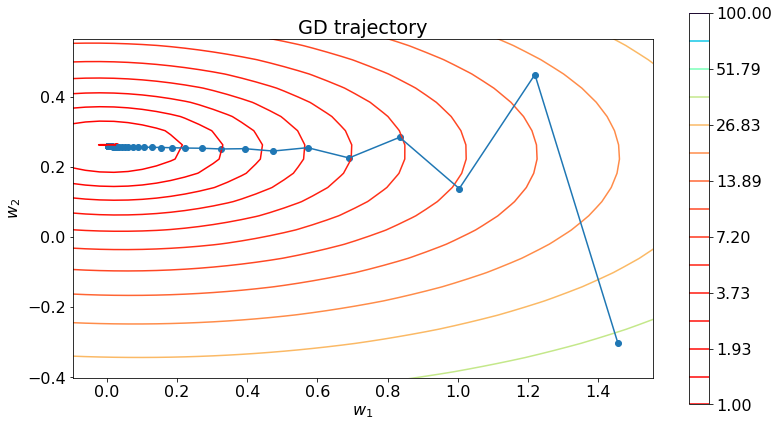

In [136]:
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))

plt.figure(figsize=(13, 9))
plt.title('GD trajectory')
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 2, num=15), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

Now let's see stohastic gradient descent (SGD)

In [137]:
np.random.seed(random_seed)
batch_size = 10
w = w_0.copy()
w_history_list = [w.copy()]
lr = 1e-2

for i in range(num_steps):
  sample_indices = np.random.choice(X.shape[0], batch_size)
  w -= lr * (2 * X[sample_indices].T.dot(X[sample_indices].dot(w) - Y[sample_indices])) / batch_size
  w_history_list.append(w.copy())
w_history_list = np.array(w_history_list)

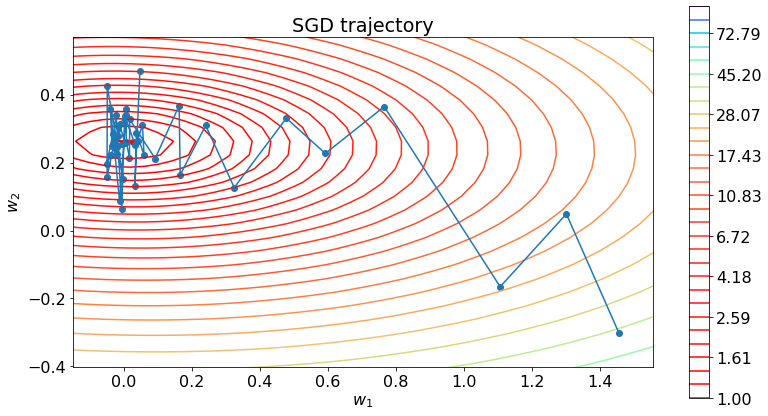

In [138]:
# compute level set
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))


plt.figure(figsize=(13, 9))
plt.title('SGD trajectory')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_history_list[:, 0].min() - 0.1, w_history_list[:, 0].max() + 0.1))
plt.ylim((w_history_list[:, 1].min() - 0.1, w_history_list[:, 1].max() + 0.1))
plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 2, num=30), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_history_list[:, 0], w_history_list[:, 1])
plt.plot(w_history_list[:, 0], w_history_list[:, 1])

plt.show()

# Comparing the convergence speed
Finally, it is important to compare the convergence speed for full and stochastic GD. Let's generate a random dataset and plot the loss function value w.r.t. iteration number

In [139]:
# data generation
n_features = 50
n_objects = 1000
num_steps = 500
batch_size = 10

w_true = np.random.uniform(-2, 2, n_features)

X = np.random.uniform(-10, 10, (n_objects, n_features))
Y = X.dot(w_true) + np.random.normal(0, 5, n_objects)

In [140]:
lr_sgd = 1e-3
lr_gd = 1e-3
w_sgd = np.random.uniform(-4, 4, n_features)
w_gd = w_sgd.copy()
residuals_sgd = [np.mean(np.power(np.dot(X, w_sgd) - Y, 2))]
residuals_gd = [np.mean(np.power(np.dot(X, w_gd) - Y, 2))]

for i in range(num_steps):
    lr = lr_sgd / ((i+1) ** 0.51)
    sample = np.random.randint(n_objects, size=batch_size)
    w_sgd -= 2 * lr * np.dot(X[sample].T, np.dot(X[sample], w_sgd) - Y[sample]) / batch_size
    residuals_sgd.append(np.mean(np.power(np.dot(X, w_sgd) - Y, 2)))
    
    w_gd -= 2 * lr_gd * np.dot(X.T, np.dot(X, w_gd) - Y) / Y.shape[0]
    residuals_gd.append(np.mean(np.power(np.dot(X, w_gd) - Y, 2)))

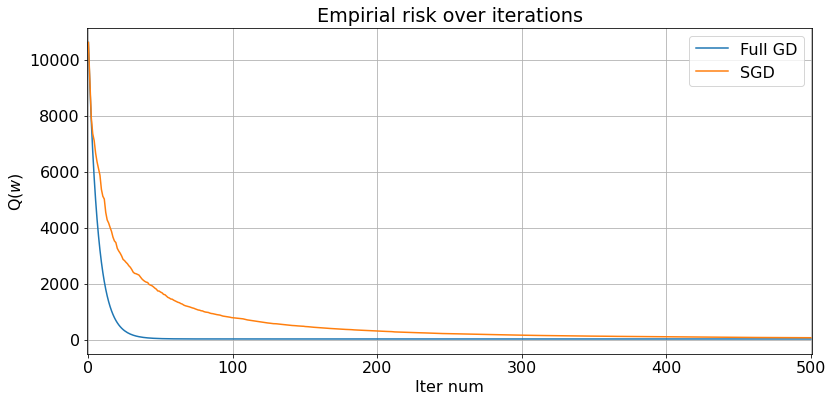

In [141]:
plt.figure(figsize=(13, 6))
plt.plot(range(num_steps+1), residuals_gd, label='Full GD')
plt.plot(range(num_steps+1), residuals_sgd, label='SGD')
plt.title('Empirial risk over iterations')
plt.xlim((-1, num_steps+1))
plt.legend()
plt.xlabel('Iter num')
plt.ylabel(r'Q($w$)')
plt.grid()
plt.show()

# Own neat version of Linear Regression
Let's use **sklearn's** standard interfaces to implement sealed version of our version of Linear Regression using SGD

First we need to inherit base classes, then implement 3 main stages of regressor life as methods:

*   hyperparameter initialization - constructor
*   parameters training on known objects - fit method
*   target estimation for unknown objects - predict method


In [142]:
# import base classes to deal with sklearn
from sklearn.base import (
    BaseEstimator, RegressorMixin, 
    ClassifierMixin, TransformerMixin
)

In [143]:
n_features = 700
n_objects = 100000
num_steps = 150

w_true = np.random.uniform(-2, 2, (n_features,1))

X = np.random.uniform(-100, 100, (n_objects, n_features)) * np.arange(n_features)
Y = X.dot(w_true) + np.random.normal(0, 10, (n_objects, 1))

In [144]:
from sklearn.model_selection import train_test_split

In [145]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)

In [146]:
class LinearRergessionSGD(BaseEstimator, RegressorMixin):

  def __init__ (
      self, C: float=1.0,
      batch_size: int=25,
      lr: float=1e-2,
      num_steps: int=200,
  ) -> None:
      self.C = C
      self.batch_size = batch_size
      self.lr = lr
      self.num_steps = num_steps

  def fit(self, X, Y):
      np.random.seed(random_seed)
      w = np.random.randn(X.shape[1])[:, None]

      for i in range(self.num_steps):
        sample_indices = np.random.randint(0, X.shape[0], size=self.batch_size)
        w -= self.lr * (2 * X[sample_indices].T.dot(X[sample_indices].dot(w) - Y[sample_indices])) / self.batch_size
      
      self.w = w
      return self

  def predict(self, X):
    return X@self.w 

In [148]:
lrs = LinearRergessionSGD()

In [149]:
from sklearn.preprocessing import StandardScaler

In [150]:
sc = StandardScaler()

In [151]:
x_tr = sc.fit_transform(x_train)

In [152]:
lrs.fit(x_tr, y_train)

LinearRergessionSGD()

In [153]:
lrs.predict(x_test)

array([[-8.05489965e+09],
       [-1.79966251e+10],
       [-1.81995144e+10],
       ...,
       [-1.64144905e+10],
       [ 1.66264082e+10],
       [-8.68298588e+09]])

NOTE! Scaling data before prediction is not a big pleasure. So we could get rid of this bulkiness with pipelines

In [154]:
from sklearn.pipeline import make_pipeline

In [155]:
pipe = make_pipeline(
    StandardScaler(),
    LinearRergessionSGD(),
)

In [156]:
pipe.fit(x_train, y_train)
pipe.predict(x_test)

array([[-113868.01513544],
       [-518663.6056067 ],
       [-525858.94805593],
       ...,
       [-514421.30418719],
       [ 326028.93970517],
       [-367124.1773436 ]])